<a href="https://colab.research.google.com/github/RogerHeederer/NLP_entry/blob/master/NERbyLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import re
%matplotlib inline
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import numpy as np

In [3]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [8]:
import pandas as pd
data = pd.read_csv("/gdrive/My Drive/RogerHeederer/NLP_entry/data/NER_train.txt", sep='\t', encoding="cp949")
data.head(3)


,-DOCSTART- -X- -X- O
0,EU NNP B-NP B-ORG
1,rejects VBZ B-VP O
2,German JJ B-NP B-MISC


In [10]:
f = open("/gdrive/My Drive/RogerHeederer/NLP_entry/data/NER_train.txt", 'r')
tagged_sentences = []
sentence = []

for line in f:
    if len(line)==0 or line.startswith('-DOCSTART') or line[0]=="\n":
        if len(sentence) > 0:
            tagged_sentences.append(sentence)
            sentence = []
        continue
    splits = line.split(' ') # 공백을 기준으로 속성을 구분한다.
    splits[-1] = re.sub(r'\n', '', splits[-1]) # 줄바꿈 표시 \n을 제거한다.
    word = splits[0].lower() # 단어들은 소문자로 바꿔서 저장한다.
    sentence.append([word, splits[-1]]) # 단어와 개체명 태깅만 기록한다.

In [11]:
print("전체 샘플 개수: ", len(tagged_sentences))

전체 샘플 개수:  14040


In [12]:
print(tagged_sentences[0])

[['eu', 'B-ORG'], ['rejects', 'O'], ['german', 'B-MISC'], ['call', 'O'], ['to', 'O'], ['boycott', 'O'], ['british', 'B-MISC'], ['lamb', 'O'], ['.', 'O']]


In [14]:
#개채명과 태깅 정보 분리
sentences, ner_tags = [], []
for tagged_sentence in tagged_sentences:
  sentence, tag_info = zip(*tagged_sentence)
  sentences.append(list(sentence))
  ner_tags.append(list(tag_info))

In [15]:
print(sentences[0])
print(ner_tags[0])

['eu', 'rejects', 'german', 'call', 'to', 'boycott', 'british', 'lamb', '.']
['B-ORG', 'O', 'B-MISC', 'O', 'O', 'O', 'B-MISC', 'O', 'O']


In [16]:
print(sentences[12])
print(ner_tags[12])

['only', 'france', 'and', 'britain', 'backed', 'fischler', "'s", 'proposal', '.']
['O', 'B-LOC', 'O', 'B-LOC', 'O', 'B-PER', 'O', 'O', 'O']


샘플의 최대 길이 : 113
샘플의 평균 길이 : 14.502635


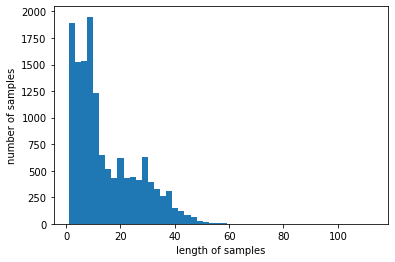

In [17]:
print('샘플의 최대 길이 : %d' % max(len(l) for l in sentences))
print('샘플의 평균 길이 : %f' % (sum(map(len, sentences))/len(sentences)))
plt.hist([len(s) for s in sentences], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [18]:
max_words = 4000 # 빈도 상위 4000개 제한
#Sentence
src_tokenizer = Tokenizer(num_words=max_words, oov_token='OOV')
src_tokenizer.fit_on_texts(sentences)
#tagging
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(ner_tags)

In [19]:
vocab_size = max_words
tag_size = len(tar_tokenizer.word_index) + 1
print('단어 집합의 크기 : {}'.format(vocab_size))
print('개체명 태깅 정보 집합의 크기 :{}'.format(tag_size))

단어 집합의 크기 : 4000
개체명 태깅 정보 집합의 크기 :10


In [21]:
#정수 인코딩 수행
X_train = src_tokenizer.texts_to_sequences(sentences)
y_train = tar_tokenizer.texts_to_sequences(ner_tags)

In [29]:
print(X_train[0])
print(y_train[0])

[989, 1, 205, 629, 7, 3939, 216, 1, 3]
[4, 1, 7, 1, 1, 1, 7, 1, 1]


In [33]:
index_to_word = src_tokenizer.index_word
index_to_ner = tar_tokenizer.index_word

In [36]:
index_to_word[7], index_to_ner[7]

('to', 'b-misc')

In [37]:
decoded = []
for index in X_train[0] : # 첫번째 샘플 안의 인덱스들에 대해서
    decoded.append(index_to_word[index]) # 다시 단어로 변환

print('기존 문장 : {}'.format(sentences[0]))
print('빈도수가 낮은 단어가 OOV 처리된 문장 : {}'.format(decoded))

기존 문장 : ['eu', 'rejects', 'german', 'call', 'to', 'boycott', 'british', 'lamb', '.']
빈도수가 낮은 단어가 OOV 처리된 문장 : ['eu', 'OOV', 'german', 'call', 'to', 'boycott', 'british', 'OOV', '.']


In [38]:
#앞서 본 그래프에서는 대부분 샘플은 길이가 70 이내

max_len = 70
X_train = pad_sequences(X_train, padding='post', maxlen = max_len)
y_train = pad_sequences(y_train, padding='post', maxlen=max_len)

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=.2, random_state=777)

In [40]:
y_train = to_categorical(y_train, num_classes=tag_size)
y_test = to_categorical(y_test, num_classes=tag_size)

In [41]:
print('훈련 샘플 문장의 크기 : {}'.format(X_train.shape))
print('훈련 샘플 레이블의 크기 : {}'.format(y_train.shape))
print('테스트 샘플 문장의 크기 : {}'.format(X_test.shape))
print('테스트 샘플 레이블의 크기 : {}'.format(y_test.shape))

훈련 샘플 문장의 크기 : (11232, 70)
훈련 샘플 레이블의 크기 : (11232, 70, 10)
테스트 샘플 문장의 크기 : (2808, 70)
테스트 샘플 레이블의 크기 : (2808, 70, 10)


##데이터 전처리 끝났으니 모델 만들기

In [42]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Bidirectional, TimeDistributed
from keras.optimizers import Adam

In [43]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=128, input_length=max_len, mask_zero=True))
# zero padding에 의해 숫자 0이 많아질 경우에는 mask_zero를 활용해 숫자 0은 패딩을 의미하니까 연산에서 제외해도 된다는 옵션을 줌
model.add(Bidirectional(LSTM(256, return_sequences=True)))
model.add(TimeDistributed(Dense(tag_size, activation='softmax')))

In [45]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])
model.fit(X_train, y_train, batch_size=128, epochs=8,  validation_data=(X_test, y_test))

Epoch 1/8
88/88 [==============================] - 121s 1s/step - loss: 0.1831 - accuracy: 0.8253 - val_loss: 0.1210 - val_accuracy: 0.8326
Epoch 2/8
88/88 [==============================] - 121s 1s/step - loss: 0.0942 - accuracy: 0.8620 - val_loss: 0.0734 - val_accuracy: 0.8933
Epoch 3/8
88/88 [==============================] - 118s 1s/step - loss: 0.0623 - accuracy: 0.9091 - val_loss: 0.0533 - val_accuracy: 0.9245
Epoch 4/8
88/88 [==============================] - 115s 1s/step - loss: 0.0450 - accuracy: 0.9363 - val_loss: 0.0416 - val_accuracy: 0.9432
Epoch 5/8
88/88 [==============================] - 119s 1s/step - loss: 0.0340 - accuracy: 0.9520 - val_loss: 0.0359 - val_accuracy: 0.9503
Epoch 6/8
88/88 [==============================] - 119s 1s/step - loss: 0.0272 - accuracy: 0.9611 - val_loss: 0.0336 - val_accuracy: 0.9533
Epoch 7/8
88/88 [==============================] - 116s 1s/step - loss: 0.0235 - accuracy: 0.9656 - val_loss: 0.0341 - val_accuracy: 0.9535
Epoch 8/8
88/88 [===

In [46]:
print("\n 테스트 정확도 : %.4f" %(model.evaluate(X_test, y_test)[1]))

88/88 [==============================] - 13s 145ms/step - loss: 0.0334 - accuracy: 0.9581

 테스트 정확도 : 0.9581


In [50]:
X_test[10]

array([2571, 1121,    4, 1064,  743, 1436,   20,    1,    1,    6,   38,
          1, 1380,   13,   87, 2639, 2648,    4,  285,  676,  856,   19,
          2,  402,  145,  724,   13,   92,  543,    7,    1,   87,  612,
        224,   15, 2003,  619, 1548,    3,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0], dtype=int32)

In [51]:
y_test[10]

array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 

In [52]:
i=10 # 확인하고 싶은 테스트용 샘플의 인덱스.
y_predicted = model.predict(np.array([X_test[i]])) # 입력한 테스트용 샘플에 대해서 예측 y를 리턴
y_predicted = np.argmax(y_predicted, axis=-1) # 원-핫 인코딩을 다시 정수 인코딩으로 변경함.
true = np.argmax(y_test[i], -1) # 원-핫 인코딩을 다시 정수 인코딩으로 변경함.

print("{:15}|{:5}|{}".format("단어", "실제값", "예측값"))
print(35 * "-")

for w, t, pred in zip(X_test[i], true, y_predicted[0]):
    if w != 0: # PAD값은 제외함.
        print("{:17}: {:7} {}".format(index_to_word[w], index_to_ner[t].upper(), index_to_ner[pred].upper()))

단어             |실제값  |예측값
-----------------------------------
sarah            : B-PER   B-PER
brady            : I-PER   I-PER
,                : O       O
whose            : O       O
republican       : B-MISC  B-MISC
husband          : O       O
was              : O       O
OOV              : O       O
OOV              : O       O
in               : O       O
an               : O       O
OOV              : O       O
attempt          : O       O
on               : O       O
president        : O       O
ronald           : B-PER   B-PER
reagan           : I-PER   I-PER
,                : O       O
took             : O       O
centre           : O       O
stage            : O       O
at               : O       O
the              : O       O
democratic       : B-MISC  B-MISC
national         : I-MISC  I-MISC
convention       : I-MISC  I-MISC
on               : O       O
monday           : O       O
night            : O       O
to               : O       O
OOV              : O       O
pre